# Exercise 05 ANN for Binary Classificatoin - Instruction

## Pedagogy

This notebook serves as an instruction for implementing ANNs using Pytorch to develop binary classification models.

Please use this notebook as a reference and guide to complete the assignment.

### Import libraries

In [1]:
# import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

## Part 1. Logistic Regression for binary classification

### Step 1. Build the data pipeline

We will use a toy dataset, the breast cancer wisconsin dataset, from `sklearn`. You can find more detials about this dataset at this [link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).

As the diabetes dataset is a tabular dataset that consists of numerical feature and target variables. We can use `torch.utils.data.TensorDataset`, a custom class that inherits from the `torch.utils.data.Dataset` class.

In this step, we need to:
1. Use `sklearn.datasets.load_breast_cancer()` to load the dataset
2. Perform feature scaling for the numerical feature variables
3. Divide the dataset into the training, <span style="color:red">validation</span>, and test set
    - We can still use `sklearn.model_selection.train_test_split()`
    - First divide the entire dataset into the train+val set and the test set
    - Then divide the train+val set into the train set and the val set 
5. Create `TensorDataset` instances to store the training, <span style="color:red">validation</span>, and test set
6. Create `DataLoader` instances to wrap the training, <span style="color:red">validation</span>, and test set as iterable objects

In [2]:
# load brease cancer dataset
feature, label = datasets.load_breast_cancer(
    return_X_y = True,
    as_frame = False, # get data as numpy array
)

In [3]:
# feature scaling
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(feature)

In [4]:
# Split the dataset into train, validation, and test sets
train_val_feature, test_feature, train_val_label, test_label = train_test_split(
    scaled_feature, label, test_size = 0.2, random_state = 0
)
train_feature, val_feature, train_label, val_label = train_test_split(
    train_val_feature, train_val_label, test_size = 0.25, random_state = 0
)

- 20% of data is used as the test set
- 80%$\times$25%=20% of data is used as the validation set
- The rest 60% of data is used as the training set

In [5]:
# create the train, validatoin, and test dataset
# specify the type of data stored in the tensors to avoid incompatiblity
train_ds = TensorDataset(
    torch.tensor(train_feature, dtype = torch.float32),
    torch.tensor(train_label, dtype = torch.float32)
)
val_ds = TensorDataset(
    torch.tensor(val_feature, dtype = torch.float32),
    torch.tensor(val_label, dtype = torch.float32)
)
test_ds = TensorDataset(
    torch.tensor(test_feature, dtype = torch.float32),
    torch.tensor(test_label, dtype = torch.float32)
)

In [6]:
# create the train and test data loaders
batch_size = 64 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

### Step 2. Create the artificial neural network

To define a neural network in `PyTorch`, we create a class that inherits from `torch.nn.Module`.

Use an ANN as a logistic regression model means:
- One-layer network
    - The number of input neurons is equal to the number of input features
    - Only one output neuron
- <span style="color:red">The activation function of the output neuron is `nn.Sigmoid()`</span>

In [19]:
# define a custom neural network class
class LogisticRegressionNet(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 1),
            nn.Sigmoid()
        )
    def forward(self, X):
        return self.net(X)

In [20]:
# create the neural network
model = LogisticRegressionNet(n_features = feature.shape[1])

### Step 3. Train the network

We define a `train()` function to perform the training process, which takes the following parameters:
- A data loader of the training set
- <span style="color:red">A data loader of the validation set</span>
- A loss function (<span style="color:red">use `nn.BCELoss()` for binary classification</span>)
- An optimizer
    - We also add <span style="color:red">L2 Regularization</span> through the `weight_decay` parameter of the optimizer
    - We implement <span style="color:red">learning rate decay</span> by monitoring the loss on validation set
    - We implement <span style="color:red">early stopping</span> by monitoring the loss on validation set
- The number of epoches to train

In a single training loop, we need to:
1. Make predictions on the training set (in batches)
2. Compute the loss on the training set (in batches)
3. Update network parameters according to gradients (in batches)
4. <span style="color:red">Make predictions on the validation set (in batches)</span>
5. <span style="color:red">Compute the loss on the validation set (in batches)</span>
6. <span style="color:red">Monitor the changes in the validation loss (in epoch), to:</span>
    - <span style="color:red">Perform leanring rate decay</span>
    - <span style="color:red">Perform early stopping</span>

In [21]:
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss = np.inf # initialize the val loss as an infinite positive value
    patience_counter = 0 # set the initial patience counter to zero
    train_batch_loss_history = [] # for recording the average train loss of a batch
    train_epoch_loss_history = [] # for recording the average train loss of an epoch
    val_batch_loss_history = [] # for recording the average val loss of an batch
    val_epoch_loss_history = [] # for recording the average val loss of an epoch
    
    # start training
    for epoch in range(epochs): # iterate pre-defined number of epoches
        # train set
        train_epoch_loss = 0.0 # initial train epoch loss is set to zero
        model.train() # set the model in training mode
        for (X, y) in train_dl: # get a batch of training samples
            prob = model(X).squeeze() # make predictions, squeeze() reduce `prob` to 1D tensor
            train_batch_loss = loss_fn(prob, y) # compute the current train batch loss
            train_batch_loss.backward() # compute gradients by backpropagation
            optimizer.step() # update learning parameters according to gradients
            optimizer.zero_grad() # reset the gradients to zero
            train_batch_loss_history.append(train_batch_loss.item()) # record current train batch loss
            train_epoch_loss += train_batch_loss.item() # accumulate train batch losses for compute train epoch loss
        train_epoch_loss /= len(train_dl) # compute current train epoch loss
        train_epoch_loss_history.append(train_epoch_loss) # record current train epoch loss
        # validation set
        val_epoch_loss = 0.0 # initial val epoch loss is set to zero
        model.eval() # set the model in evaluation mode
        with torch.no_grad():
            for (X, y) in val_dl: # get a batch of validation samples
                prob = model(X).squeeze() # make predictions, squeeze() reduce `prob` to 1D tensor
                val_batch_loss = loss_fn(prob, y) # compute the current val batch loss
                val_batch_loss_history.append(val_batch_loss.item()) # record current val batch loss
                val_epoch_loss += val_batch_loss.item() # accumulate val batch losses for compute val epoch loss
            val_epoch_loss /= len(val_dl) # compute current val epoch loss
            val_epoch_loss_history.append(val_epoch_loss) # record current val epoch loss
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}") # print log
        # learning rate decay
        old_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if old_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}')
        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss # update the new min val loss
            patience_counter = 0 # reset patience counter to zero
        else:
            patience_counter += 1 # increase patience counter by 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return train_batch_loss_history, val_batch_loss_history, train_epoch_loss_history, val_epoch_loss_history

In [22]:
# define the training hyper-parameters
loss_fn = nn.BCELoss() # binary cross entropy loss
learning_rate = 1e-1
weight_decay = 1e-5 # lambda for L2 regularization
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1, # each step multiply the learning rate with 0.1
    patience = 5
)

In [23]:
# train the neural network
train_batch_loss_history, val_batch_loss_history, train_epoch_loss_history, val_epoch_loss_history = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)

Epoch 1: train loss = 0.449130, val loss = 0.279108
Epoch 2: train loss = 0.265293, val loss = 0.211120
Epoch 3: train loss = 0.212096, val loss = 0.179321
Epoch 4: train loss = 0.182489, val loss = 0.159139
Epoch 5: train loss = 0.160087, val loss = 0.145765
Epoch 6: train loss = 0.151201, val loss = 0.136043
Epoch 7: train loss = 0.133948, val loss = 0.128515
Epoch 8: train loss = 0.127469, val loss = 0.122960
Epoch 9: train loss = 0.124510, val loss = 0.118210
Epoch 10: train loss = 0.120898, val loss = 0.113900
Epoch 11: train loss = 0.124186, val loss = 0.110776
Epoch 12: train loss = 0.111044, val loss = 0.107531
Epoch 13: train loss = 0.109827, val loss = 0.104792
Epoch 14: train loss = 0.113518, val loss = 0.101915
Epoch 15: train loss = 0.108488, val loss = 0.100231
Epoch 16: train loss = 0.099840, val loss = 0.098652
Epoch 17: train loss = 0.102764, val loss = 0.096975
Epoch 18: train loss = 0.099845, val loss = 0.095399
Epoch 19: train loss = 0.105207, val loss = 0.094429
Ep

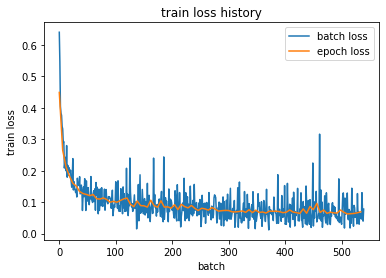

In [24]:
# plot the train loss history
plt.figure()
batch = np.arange(len(train_batch_loss_history))
epoch = np.arange(len(train_epoch_loss_history))
batches_per_epoch = (int(len(train_feature) / batch_size + 1))
plt.plot(batch, train_batch_loss_history, '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, train_epoch_loss_history, '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

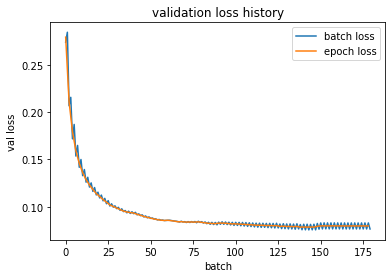

In [25]:
# plot the val loss history
plt.figure()
batch = np.arange(len(val_batch_loss_history))
epoch = np.arange(len(val_epoch_loss_history))
batches_per_epoch = (int(len(val_feature) / batch_size + 1))
plt.plot(batch, val_batch_loss_history, '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, val_epoch_loss_history, '-', label = 'epoch loss')
plt.title('validation loss history')
plt.xlabel('batch')
plt.ylabel('val loss')
plt.legend()
plt.show()

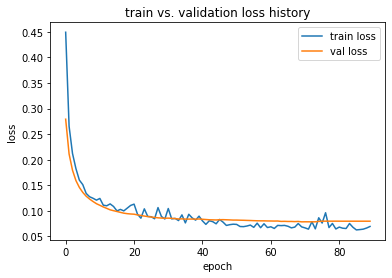

In [26]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(train_epoch_loss_history)), train_epoch_loss_history, '-', label = 'train loss')
plt.plot(np.arange(len(val_epoch_loss_history)), val_epoch_loss_history, '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Step 4. Save and load the trained model

In [27]:
# save model
file_name = 'logistic_regression_net.pth'
torch.save(model.state_dict(), file_name)
print('Saved PyTorch Model State to '+ file_name)

Saved PyTorch Model State to logistic_regression_net.pth


In [28]:
# load model
model = LogisticRegressionNet(n_features = feature.shape[1])
model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

### Step 5. Make predictions and evaluation

Make predictions on the test set and evaluation the performance of the network.

To do that in batch, we can define a `test()` function, which is similar to the `train` function but much simpler.

Note that, <span style="color:red">the output of the logistic regression network is the probabilities belongs to the positive class. We need to convert the probabilities to categorical predictions by a threshold.</span> Then we can use the classification metrics to evaluate the performance.

In [29]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    batch_prob_list = [] # for recording batch predictions
    model.eval() # set the model in evaluation mode
    with torch.no_grad(): # disable automatic gradient computing
        loss = 0.0 # set initial test loss to zero
        for (X, y) in dataloader: # get a batch from test samples
            batch_prob = model(X).squeeze() # make predictions, squeeze() reduce `batch_prob` to 1D tensor
            batch_loss = loss_fn(batch_prob, y) # compute current batch loss
            loss += batch_loss.item() # accumulate batch losses for compute test loss
            batch_prob_list.append(batch_prob) # record predictions on current batch
        loss /= len(dataloader) # compute test loss
        prob = np.concatenate(batch_prob_list) # reform the predictions as a numpy 1D array
        print(f"test loss = {loss}") # print log
    return prob, loss

In [30]:
# make prediction on test set and evaluate the performance
test_prob, test_loss = test(test_dl, model, loss_fn)
test_pred = (test_prob > 0.5) # convert the probability to predicted class by a threshold
print(classification_report(test_label, test_pred))

test loss = 0.09969466552138329
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        47
           1       0.96      0.97      0.96        67

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## Part 2. Multi-layer ANN for binary classification

Instead of using an one-layer ANN that behaves like a logistic regression model, we can also define a multi-layer ANN as a binary classifer with higher capacity.

For example, we can define a deeper and more complex ANN as follows:

In [31]:
# define a custom neural network class
class BinaryClassificationNet(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )
    def forward(self, X):
        return self.net(X)

In [32]:
# create the neural network
model = BinaryClassificationNet(n_features = feature.shape[1])

<span style="color:red">Now let's train a binary classifier using the above defined neural network structure to see if you can improve the performance.</span>
- You can change the following options to see the effects on the training process:
    - batch size
    - number of layers and neurons
    - activation functions
    - lambda of L2 regularization
    - early stopping patience
    - learning rate decay patience